# Bias in Word Embeddings

In this notebook we'll demonstrate the gender bias in word embeddings. 

We will use GloVe embeddings and project "feminine" vs. "masculine" occupations to show that the vectors indeed capture this bias.

The [professions file](https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/professions.json) is taken from the paper: 

**Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings** 
*Tolga Bolukbasi, Kai-Wei Chang, James Zou, Venkatesh Saligrama, and Adam Kalai.* NIPS 2016. 

In [1]:
import os
import json
import gzip
import random
import codecs

import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

### Load word embeddings:

Download GloVe or open it from the local directory if it was already downloaded.

In [2]:
def load_embeddings(file_name):
    """
    Load the pre-trained embeddings from a file
    :param file_name: the embeddings file
    :return: the vocabulary and the word vectors
    """
    with gzip.open(file_name, 'rt', 'utf-8') as f_in:
        lines = [line.strip() for line in f_in]

    embedding_dim = len(lines[0].split()) - 1
    index2word, vectors = zip(*[line.strip().split(' ', 1) 
                                for line in lines 
                                if len(line.split()) == embedding_dim + 1])
    wv = np.loadtxt(vectors)
    return wv, index2word


LOCAL_EMB_PATH = os.path.expanduser('~/word_embeddings/glove/glove.6B.50d.txt.gz')
REMOTE_EMB_PATH = 'https://s3-us-west-2.amazonaws.com/allennlp/datasets/glove/glove.6B.50d.txt.gz'

if not os.path.exists(LOCAL_EMB_PATH):
    print(f'Downloading embeddings from {REMOTE_EMB_PATH}')
    local_dir = os.path.dirname(LOCAL_EMB_PATH)
    !mkdir -p $local_dir
    !wget $REMOTE_EMB_PATH -O $LOCAL_EMB_PATH

print(f'Loading embeddings from {LOCAL_EMB_PATH}')
wv, index2word = load_embeddings(LOCAL_EMB_PATH)
word2index = {w:i for i, w in enumerate(index2word)}

Loading embeddings from /home/vered/word_embeddings/glove/glove.6B.50d.txt.gz


Load the list of common occupations.

Format: 
- occupation
- definitional female -1.0 -> definitional male 1.0
- stereotypical female -1.0 -> stereotypical male 1.0

We take everything that is not defined to one gender only, but is stereotypical to this gender.

In [3]:
LOCAL_OCC_PATH = 'professions.json'
REMOTE_OCC_PATH = 'https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/professions.json'

if not os.path.exists(LOCAL_OCC_PATH):
    !wget $REMOTE_OCC_PATH
    
with open(LOCAL_OCC_PATH) as f_in:
    occupations = json.load(f_in)
    
female_occupations = [occ for occ, def_f, ste_f in occupations if def_f != -1 and def_f <= 0 and ste_f < 0]
male_occupations = [occ for occ, def_f, ste_f in occupations if def_f != 1 and def_f >= 0 and ste_f > 0]
stereotypes = [occ for occ, def_f, ste_f in occupations if abs(def_f) == 1]
occupations = female_occupations + male_occupations + stereotypes

print('"Male" occupations:')
print('\n'.join(male_occupations[:10]))
print('')

print('"Female" occupations:')
print('\n'.join(female_occupations[:10]))

"Male" occupations:
accountant
adjunct_professor
administrator
adventurer
alderman
ambassador
analyst
anthropologist
archaeologist
archbishop

"Female" occupations:
advocate
aide
artist
artiste
baker
ballerina
bookkeeper
businesswoman
caretaker
choreographer


Limit the word vectors to this vocabulary. 

In [4]:
def get_vector(w, curr_wv=wv, curr_word2index=word2index):
    if w in curr_word2index:
        return curr_wv[curr_word2index[w], :]
    else:
        return None
    
vocab = occupations + ['he', 'she']
word_vectors = [get_vector(w) for w in vocab]
filtered_index2word, filtered_wv = zip(*[
    (w, v) for v, w in zip(word_vectors, vocab) if v is not None])
filtered_word2index = {w:i for i, w in enumerate(filtered_index2word)}
filtered_wv = np.vstack(filtered_wv)

Define the code to solve analogies as in the word2vec paper.

In [5]:
all_norms = [np.linalg.norm(filtered_wv[i, :]) 
             for i in range(len(filtered_index2word))]


def most_similar_word(v, index_to_exclude=None):
    """
    Returns the most similar word to a vector v, using cosine similarity
    """
    # Apply matrix-vector dot product to get the dot product of w to all the other vectors
    dot_product = np.dot(filtered_wv, v)

    # Compute cosine similarity. We don't need to divide by the norm of v because
    # it is constant across all words. We only need to divide by the norm of each word vector.
    norm_v = np.linalg.norm(v)
    cosine = dot_product / all_norms
    
    if index_to_exclude is not None:
        best_index = [i for i in np.argsort(cosine)[::-1] if i != index_to_exclude][0] 
    else:
        best_index = np.argmax(cosine)
        
    return (filtered_index2word[best_index], cosine[best_index])


def solve_analogy(a, b, c, threshold=-np.inf):
    """
    d* = argmax_d(cos(b - a + c, d))
    """
    vectors = []
    for x in [a, b, c]:
        curr = get_vector(x, curr_wv=filtered_wv, curr_word2index=filtered_word2index)
        if curr is None:
            return None, -np.inf
        vectors.append(curr)
    
    v_a, v_b, v_c = vectors
    d, score = most_similar_word(v_b - v_a + v_c, index_to_exclude=filtered_word2index[b])
    
    if score >= threshold:
        return d, score
    else:
        return None, -np.inf
    

solution, score = solve_analogy('he', 'doctor', 'she')
print(f'he : doctor :: she : {solution}')

he : doctor :: she : nurse


First demonstration of bias. 

Now, let's follow Bolukbasi et al. and define the analogies on the "gender direction". 

We will find analogies of type: *he : occupation_1 :: she : occupation_2* for a select number of "masculine" occupations.

In [14]:
word_pairs = [(('he', 'she'), np.inf)]

for b in male_occupations:
    if b in {'he', 'she'}:
        continue
        
    d, score = solve_analogy('he', b, 'she')
    if d is not None:
        word_pairs.append(((b, d), score))

        
# Sort by score and take the 25 highest scoring pairs
word_pairs = [(b, d) for (b, d), score in sorted(word_pairs, key=lambda x: x[1], reverse=True)][:25]
print('\n'.join([':'.join(pair) for pair in word_pairs]))

he:she
composer:pianist
guitarist:vocalist
envoy:ambassador
painter:sculptor
professor:researcher
minister:deputy
drummer:vocalist
comedian:actress
playwright:filmmaker
doctor:nurse
economist:analyst
columnist:editor
scientist:researcher
screenwriter:filmmaker
saxophonist:vocalist
editor:columnist
attorney:lawyer
narrator:protagonist
filmmaker:actress
surgeon:nurse
legislator:lawmaker
strategist:analyst
physicist:scientist
cardiologist:pediatrician


Now let's plot a t-SNE projection, including lines between the word pairs. 

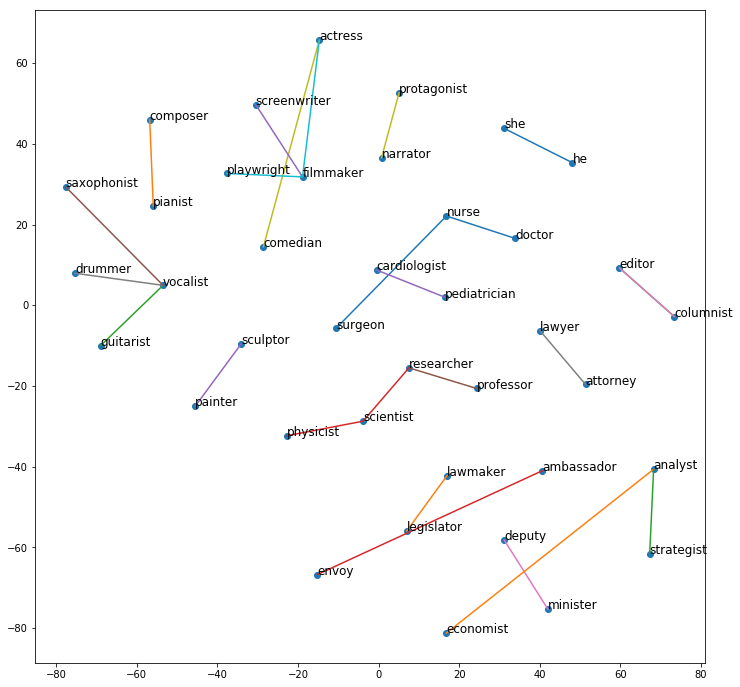

In [15]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE


def plot_tsne(word_pairs):
    """
    Plot a t-SNE projection of the word embeddings,
    and draw lines between the word pairs (pairs of indices).
    """
    projector = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    
    # Limit the vocabulary 
    w1s, w2s = zip(*word_pairs)
    limited_vocab = list(set(w1s).union(w2s)) 
    curr_word2index = {w:i for i, w in enumerate(limited_vocab)}
    curr_wv = np.vstack([get_vector(w) for w in limited_vocab])
    Y = projector.fit_transform(curr_wv)

    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes()
    ax.scatter(Y[:, 0], Y[:, 1])
    for w, x, y in zip(limited_vocab, Y[:, 0], Y[:, 1]):
        ax.annotate(w, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=12)

    # Draw lines
    for b, d in word_pairs:
        indices = [curr_word2index[b], curr_word2index[d]]
        i, j = min(indices), max(indices)    
        plt.plot([Y[i, 0], Y[j, 0]], [Y[i, 1], Y[j, 1]])
    
    plt.show()


plot_tsne(word_pairs)

It's not a very strong signal, but we can see that the projection of some word pairs has a similar direction as *he:she*: *doctor:nurse*, *professor:researcher*, *minister:deputy*, etc. 